In [1]:
# fmt: off
import urllib

from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02b_neural_network.ipynb"
_nb_title = "Flowers Image Classification using a neural network"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), f"https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{_nb_loc}", f"https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{_nb_loc}", f"https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{_nb_loc}"]
md(f"""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{_links[0]}"><img src="{_icons[0]}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{_links[1]}"><img src="{_icons[1]}" />Run in Google Colab</a></td><td><a target="_blank" href="{_links[2]}"><img src="{_icons[2]}" />View source on GitHub</a></td><td><a href="{_links[3]}"><img src="{_icons[3]}" />Download notebook</a></td></table><br/><br/>""")
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Flowers+Image+Classification+using+a+neural+network&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# ニューラルネットワークを使用した花の画像分類  

このノートブックでは、tf-flowersデータセットを分類するためのニューラルネットワークを構築する方法を示します。  

データ探索の多くは、コンパニオンノートブック02a_machine_perception.ipynbで行われました。  


## Keras Tunerのインストール
ハイパーパラメータチューニングで利用するKeras Tunerをインストールします。

**以下を実行し、ノートブックのカーネルを再起動してから次に進んでください**

In [2]:
!pip install --user keras-tuner

In [3]:
import os
import warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import keras_tuner as kt

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


## GPUを有効にする  

このノートブックは、GPUが接続された環境での実行を推奨しています。

Vertex AI WorkbenchやColabでGPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [4]:
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(f"Found GPU at: {device_name}")

2.12.0
Found GPU at: /device:GPU:0


## ヘルパー関数の定義
ヘルパー関数を定義します。

In [5]:
# 学習の可視化
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls="dashed")
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history["val_" + metric])
        ax[idx].legend([metric, "val_" + metric])

### データ読み込みパイプラインの作成
データ読み込み
[`02a_machine_perception.ipynb`](https://github.com/takumiohym/practical-ml-vision-book-ja/blob/main/02_ml_models/02a_machine_perception.ipynb)と同様のデータ読み込みモジュールを作成します。

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3


def read_and_decode(filename, reshape_dims):
    # 1. ファイルを読み込む
    img = tf.io.read_file(filename)
    # 2. 圧縮された文字列を3次元のuint8のテンソルに変換する
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # 3. 3次元のuint8を[0, 1]の範囲の浮動小数点数に変換する
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. 画像を必要なサイズにリサイズする
    return tf.image.resize(img, reshape_dims)


CLASS_NAMES = [
    item.numpy().decode("utf-8")
    for item in tf.strings.regex_replace(
        tf.io.gfile.glob(
            "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"
        ),
        "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/",
        "",
    )
]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)


def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## ニューラルネットワークモデル  

隠れ層に非線形レイヤーを1つ追加します

In [7]:
BATCH_SIZE = 32

train_dataset = (
    tf.data.TextLineDataset(
        "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
    )
    .map(decode_csv)
    .cache()
).batch(BATCH_SIZE)

eval_dataset = (
    tf.data.TextLineDataset(
        "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
    )
    .map(decode_csv)
    .cache()
).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
        ),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 71s 663ms/step - loss: 13.9313 - accuracy: 0.3336 - val_loss: 3.4104 - val_accuracy: 0.3297
Epoch 2/10
104/104 [==============================] - 1s 14ms/step - loss: 4.8468 - accuracy: 0.3591 - val_loss: 9.8811 - val_accuracy: 0.2595
Epoch 3/10
104/104 [==============================] - 1s 13ms/step - loss: 3.0103 - accuracy: 0.4027 - val_loss: 3.8111 - val_accuracy: 0.2459
Epoch 4/10
104/104 [==============================] - 1s 13ms/step - loss: 1.6884 - accuracy: 0.4103 - val_loss: 1.4233 - val_accuracy: 0.4054
Epoch 5/10
104/104 [==============================] - 1s 13ms/step - loss: 1.4435 - accuracy: 0.3558 - val_loss: 1.5494 - val_accuracy: 0.3838
Epoch 6/10
104/104 [==============================] - 1s 13ms/step - loss: 1.5308 - accuracy: 0.3515 - val_loss: 1.5523 - val_accuracy: 0.2162
Epoch 7/10
104/104 [==============================] - 1s 13ms/step - loss: 1.4850 - accuracy: 0.2973 - val_loss: 1.4899 - val_accuracy: 0.3

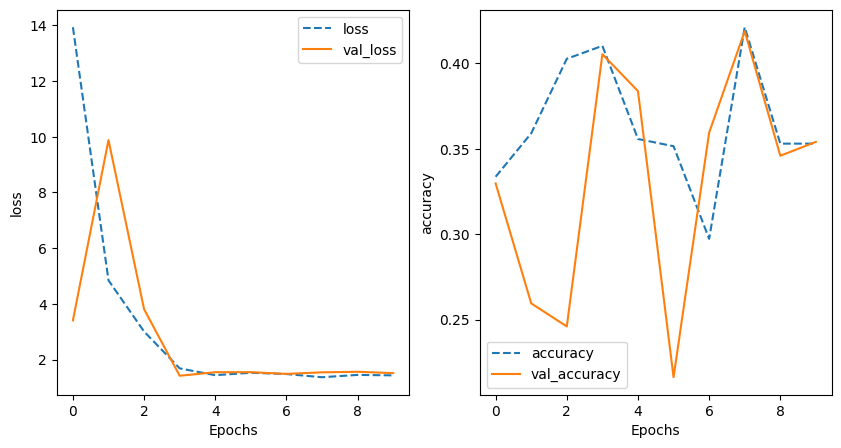

In [8]:
training_plot(["loss", "accuracy"], history)

## ハイパーパラメーターチューニング

上記のコードを`train_and_evaluate`関数にまとめて、ハイパーパラメータを引数から渡せるようにします。

In [9]:
def train_and_evaluate(
    batch_size=32,
    lrate=0.001,  # default in Adam constructor
    l1=0,
    l2=0,
    num_hidden=128,
):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (
        tf.data.TextLineDataset(
            "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
        )
        .map(decode_csv)
        .cache()
    ).batch(batch_size)

    eval_dataset = (
        tf.data.TextLineDataset(
            "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
        )
        .map(decode_csv)
        .cache()
    ).batch(batch_size)

    # 一層の隠れ層を持つNN
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
            ),
            tf.keras.layers.Dense(
                num_hidden,
                kernel_regularizer=regularizer,
                activation=tf.keras.activations.relu,
            ),
            tf.keras.layers.Dense(
                len(CLASS_NAMES),
                kernel_regularizer=regularizer,
                activation="softmax",
            ),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )

    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(["loss", "accuracy"], history)
    return model

Epoch 1/10
104/104 [==============================] - 70s 660ms/step - loss: 2.0994 - accuracy: 0.3467 - val_loss: 1.3789 - val_accuracy: 0.4081
Epoch 2/10
104/104 [==============================] - 1s 13ms/step - loss: 1.4182 - accuracy: 0.4248 - val_loss: 1.6657 - val_accuracy: 0.3730
Epoch 3/10
104/104 [==============================] - 1s 13ms/step - loss: 1.3799 - accuracy: 0.4658 - val_loss: 1.3901 - val_accuracy: 0.4216
Epoch 4/10
104/104 [==============================] - 1s 14ms/step - loss: 1.2843 - accuracy: 0.5021 - val_loss: 1.4211 - val_accuracy: 0.4297
Epoch 5/10
104/104 [==============================] - 1s 13ms/step - loss: 1.2169 - accuracy: 0.5182 - val_loss: 1.5798 - val_accuracy: 0.4514
Epoch 6/10
104/104 [==============================] - 1s 13ms/step - loss: 1.1875 - accuracy: 0.5388 - val_loss: 1.5661 - val_accuracy: 0.4351
Epoch 7/10
104/104 [==============================] - 1s 13ms/step - loss: 1.1887 - accuracy: 0.5439 - val_loss: 1.7107 - val_accuracy: 0.42

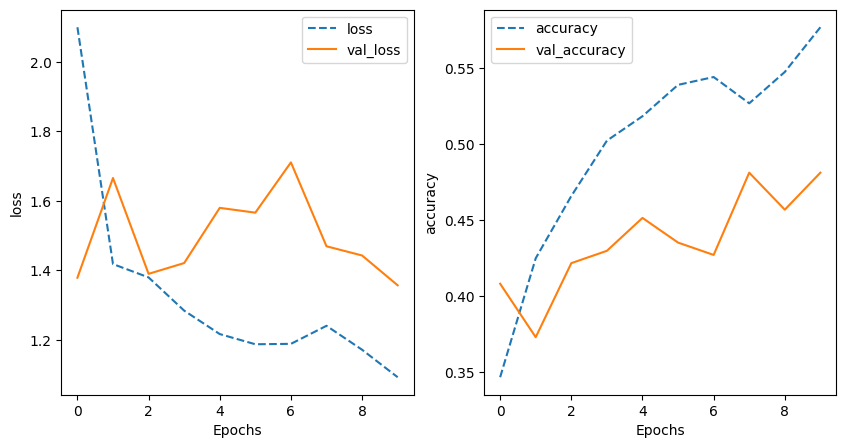

In [10]:
# 小さな学習率を設定
model = train_and_evaluate(
    batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128
)

Epoch 1/10
104/104 [==============================] - 72s 681ms/step - loss: 3.3082 - accuracy: 0.3352 - val_loss: 1.4788 - val_accuracy: 0.4270
Epoch 2/10
104/104 [==============================] - 2s 17ms/step - loss: 1.5304 - accuracy: 0.4373 - val_loss: 1.6909 - val_accuracy: 0.3973
Epoch 3/10
104/104 [==============================] - 2s 16ms/step - loss: 1.4092 - accuracy: 0.4730 - val_loss: 1.6105 - val_accuracy: 0.4216
Epoch 4/10
104/104 [==============================] - 2s 16ms/step - loss: 1.3104 - accuracy: 0.5179 - val_loss: 1.6282 - val_accuracy: 0.4351
Epoch 5/10
104/104 [==============================] - 2s 16ms/step - loss: 1.2612 - accuracy: 0.5418 - val_loss: 1.8618 - val_accuracy: 0.4108
Epoch 6/10
104/104 [==============================] - 2s 17ms/step - loss: 1.3938 - accuracy: 0.5109 - val_loss: 2.6223 - val_accuracy: 0.3892
Epoch 7/10
104/104 [==============================] - 2s 17ms/step - loss: 1.2831 - accuracy: 0.5467 - val_loss: 2.2673 - val_accuracy: 0.38

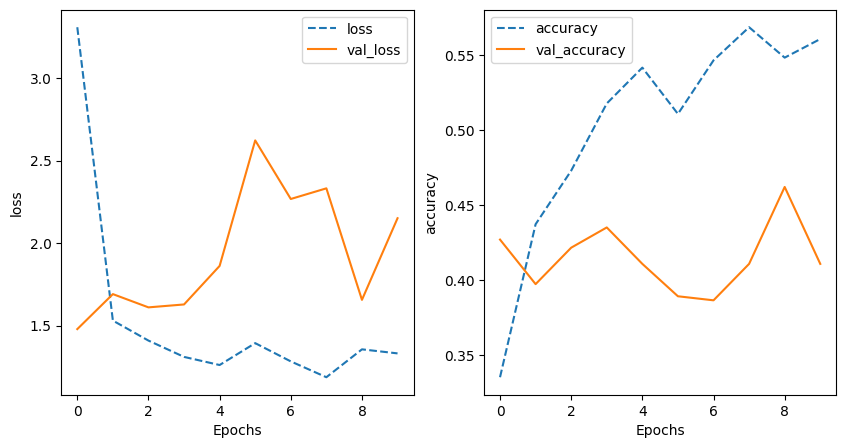

In [11]:
# 隠れ層のニューロンの数を大きくする
model = train_and_evaluate(
    batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256
)

Epoch 1/10
104/104 [==============================] - 68s 642ms/step - loss: 2.3742 - accuracy: 0.3312 - val_loss: 1.6224 - val_accuracy: 0.4216
Epoch 2/10
104/104 [==============================] - 2s 15ms/step - loss: 1.5940 - accuracy: 0.4518 - val_loss: 1.9314 - val_accuracy: 0.4108
Epoch 3/10
104/104 [==============================] - 1s 14ms/step - loss: 1.4891 - accuracy: 0.4955 - val_loss: 1.7975 - val_accuracy: 0.4459
Epoch 4/10
104/104 [==============================] - 2s 15ms/step - loss: 1.4304 - accuracy: 0.5164 - val_loss: 1.8074 - val_accuracy: 0.4486
Epoch 5/10
104/104 [==============================] - 1s 14ms/step - loss: 1.4436 - accuracy: 0.5015 - val_loss: 1.5133 - val_accuracy: 0.4459
Epoch 6/10
104/104 [==============================] - 2s 14ms/step - loss: 1.3382 - accuracy: 0.5267 - val_loss: 1.5191 - val_accuracy: 0.4757
Epoch 7/10
104/104 [==============================] - 1s 14ms/step - loss: 1.2460 - accuracy: 0.5697 - val_loss: 1.5603 - val_accuracy: 0.48

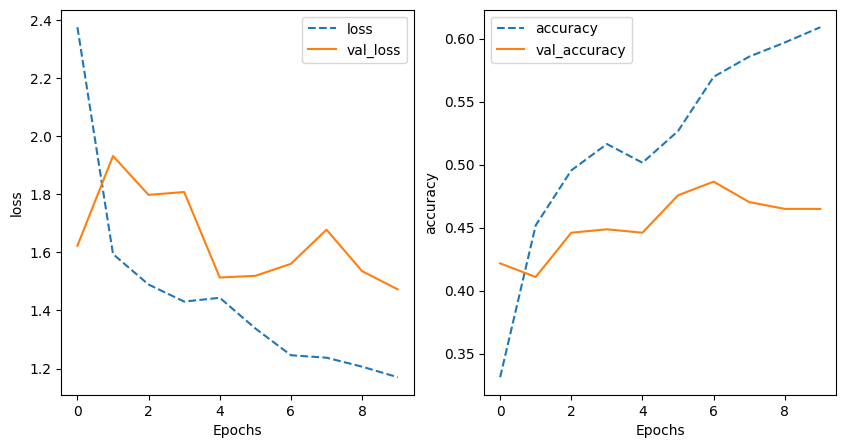

In [12]:
# L2正則化を加える
model = train_and_evaluate(
    batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128
)

## Keras Tunerを使用したハイパーパラメータチューニングの自動化

In [13]:
def build_model(hp):
    lrate = hp.Float("lrate", 1e-4, 1e-1, sampling="log")
    l1 = 0
    l2 = hp.Choice("l2", values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
    num_hidden = hp.Int("num_hidden", 32, 256, 32)

    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    # 一層の隠れ層を持つNN
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
            ),
            tf.keras.layers.Dense(
                num_hidden,
                kernel_regularizer=regularizer,
                activation=tf.keras.activations.relu,
            ),
            tf.keras.layers.Dense(
                len(CLASS_NAMES),
                kernel_regularizer=regularizer,
                activation="softmax",
            ),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    return model


batch_size = 32
train_dataset = (
    tf.data.TextLineDataset(
        "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
    )
    .map(decode_csv)
    .cache()
).batch(batch_size)

eval_dataset = (
    tf.data.TextLineDataset(
        "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
    )
    .map(decode_csv)
    .cache()
).batch(batch_size)

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_accuracy", "max"),
    max_trials=10,
    num_initial_points=2,
    overwrite=False,
)  # True: 毎回最初から実行する

tuner.search(
    train_dataset,
    validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)],
)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [14]:
topN = 1
for x in range(topN):
    print(tuner.get_best_hyperparameters(topN)[x].values)
    print(tuner.get_best_models(topN)[x].summary())

{'lrate': 0.0001, 'l2': 0.0001, 'num_hidden': 160}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 160)               24084640  
                                                                 
 dense_1 (Dense)             (None, 5)                 805       
                                                                 
Total params: 24,085,445
Trainable params: 24,085,445
Non-trainable params: 0
_________________________________________________________________
None


ハイパーパラメータの最適な組み合わせ: （実行の度に異なります）
* l2 = 0.0001、lrate = 0.0001、num_hidden = 160
* score= 0.4595

## ディープニューラルネットワーク  

より深いディープニューラルネットワークを作成し、学習してみましょう。<br>
隠れ層数と各層のノードの数をパラメーター化します

In [15]:
def train_and_evaluate(
    batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=[64, 16]
):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (
        tf.data.TextLineDataset(
            "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
        )
        .map(decode_csv)
        .cache()
    ).batch(batch_size)

    eval_dataset = (
        tf.data.TextLineDataset(
            "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
        )
        .map(decode_csv)
        .cache()
    ).batch(
        32
    )  # this doesn't matter

    # 一層の隠れ層を持つNN
    layers = [
        tf.keras.layers.Flatten(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            name="input_pixels",
        )
    ]
    layers = layers + [
        tf.keras.layers.Dense(
            nodes,
            kernel_regularizer=regularizer,
            activation=tf.keras.activations.relu,
            name=f"hidden_dense_{hno}",
        )
        for hno, nodes in enumerate(num_hidden)
    ]
    layers = layers + [
        tf.keras.layers.Dense(
            len(CLASS_NAMES),
            kernel_regularizer=regularizer,
            activation="softmax",
            name="flower_prob",
        )
    ]

    model = tf.keras.Sequential(layers, name="flower_classification")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(["loss", "accuracy"], history)
    return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 64)                9633856   
                                                                 
 hidden_dense_1 (Dense)      (None, 16)                1040      
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 69s 645ms/step - loss: 1.8127 - accuracy: 0.2321 - val_loss: 1.7537 - val_accuracy: 0.2351
Epoch 2/10
104/10

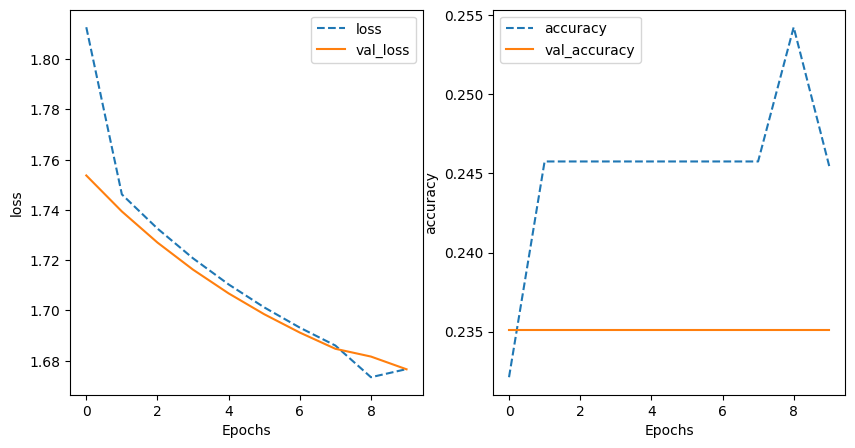

In [16]:
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden=[64, 16])

### ドロップアウトとバッチ正規化
各隠れ層の後にドロップアウトレイヤーとバッチ正規化レイヤーを追加します。  


In [17]:
def train_and_evaluate(
    batch_size=32,
    lrate=0.0001,
    l1=0,
    l2=0.001,
    dropout_prob=0.4,
    num_hidden=[64, 16],
):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (
        tf.data.TextLineDataset(
            "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
        )
        .map(decode_csv)
        .cache()
    ).batch(batch_size)

    eval_dataset = (
        tf.data.TextLineDataset(
            "gs://asl-public/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
        )
        .map(decode_csv)
        .cache()
    ).batch(32)

    # 複数の隠れ層を持つNN
    layers = [
        tf.keras.layers.Flatten(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            name="input_pixels",
        )
    ]
    for hno, nodes in enumerate(num_hidden):
        layers.extend(
            [
                tf.keras.layers.Dense(
                    nodes,
                    kernel_regularizer=regularizer,
                    name=f"hidden_dense_{hno}",
                ),
                tf.keras.layers.BatchNormalization(
                    scale=False,  # ReLU
                    center=False,  # Dense層内にバイアスがあるため
                    name=f"batchnorm_dense_{hno}",
                ),
                # Activation層をバッチ正規化の後にする
                tf.keras.layers.Activation("relu", name=f"relu_dense_{hno}"),
                tf.keras.layers.Dropout(
                    rate=dropout_prob, name=f"dropout_dense_{hno}"
                ),
            ]
        )

    layers.append(
        tf.keras.layers.Dense(
            len(CLASS_NAMES),
            kernel_regularizer=regularizer,
            activation="softmax",
            name="flower_prob",
        )
    )

    model = tf.keras.Sequential(layers, name="flower_classification")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(["loss", "accuracy"], history)
    return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 64)                9633856   
                                                                 
 batchnorm_dense_0 (BatchNor  (None, 64)               128       
 malization)                                                     
                                                                 
 relu_dense_0 (Activation)   (None, 64)                0         
                                                                 
 dropout_dense_0 (Dropout)   (None, 64)                0         
                                                                 
 hidden_dense_1 (Dense)      (None, 16)                1040      
                                             

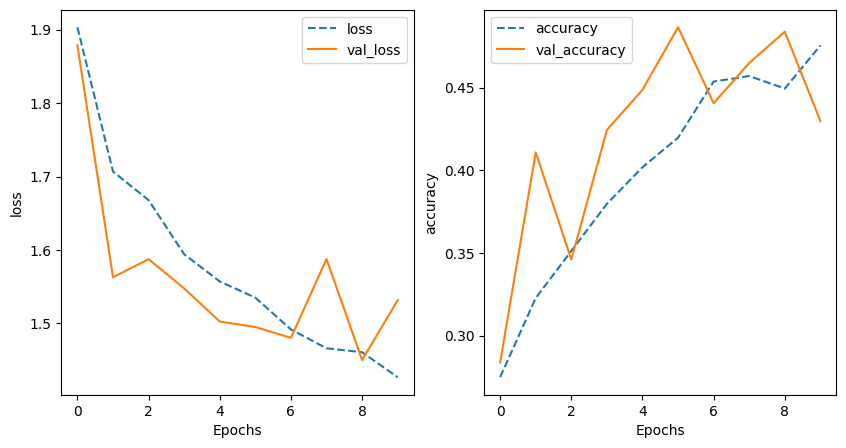

In [18]:
model = train_and_evaluate(dropout_prob=0.4)

## ダイアグラム  

これらでは本書の中で使用された図をプロットします。

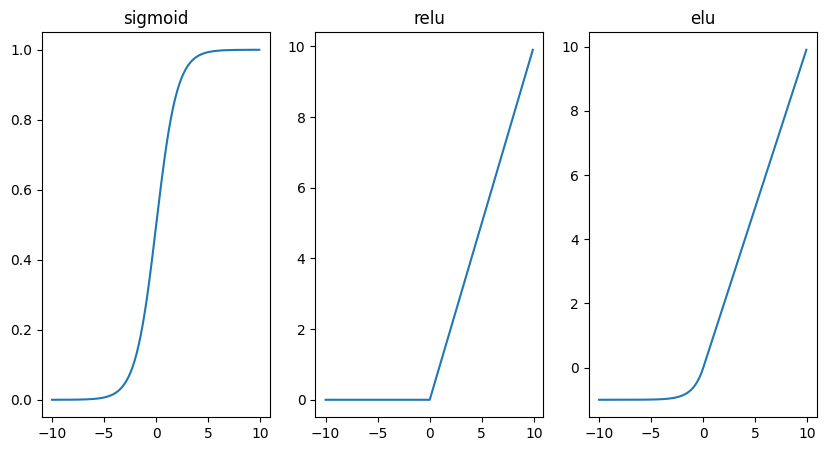

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y)
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y)
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y)
ax[2].set_title("elu");

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               19267712  
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


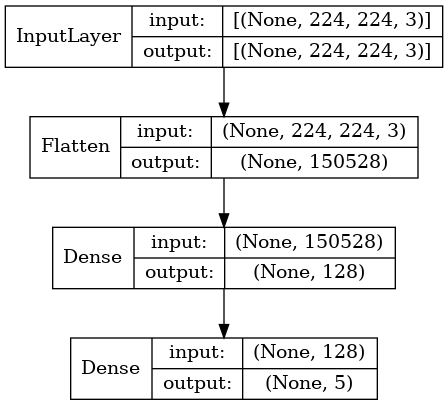

In [20]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax"),
    ]
)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [21]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.